# Code for Fig. 3 and fig. S3 of
#### Yeager et al., 2021: An Outsized Role for the Labrador Sea in the Multidecadal Variability of the Atlantic Overturning Circulation, *Science Advances*.

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def open_POPdataset(x):
    ds = xr.open_dataset(x,decode_times=False)
    attrs=ds.time.attrs.copy()
    ds = ds.assign_coords(time=ds.time.values - 15)
    ds.time.attrs = attrs
    ds = xr.decode_cf(ds)
    return ds

In [3]:
datadir = '/glade/scratch/yeager/YeagerEA_ScienceAdvances_2021/'
dir_hr = '/glade/work/yeager/iHesp/B1850/'
dir_lr = '/glade/work/yeager/iHesp/B1850_LR/'
f1_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.015001_050012.MOCsig.osnap.nc'
f1_lr = f'{datadir}/B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.000101_050012.MOCsig.osnap.nc'
f2_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.020001_050012.MOCsig.nc'
f2_lr = f'{datadir}/B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.000101_050012.MOCsig.nc'
f3_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.020001_050012.WMF.nc'
f3_lr = f'{datadir}/B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.000101_050012.WMF.nc'

ds1_hr = open_POPdataset(f1_hr) 
ds1_lr = open_POPdataset(f1_lr)
ds2_hr = open_POPdataset(f2_hr) 
ds2_lr = open_POPdataset(f2_lr)
ds3_hr = open_POPdataset(f3_hr) 
ds3_lr = open_POPdataset(f3_lr)

## Compute Anomalies and Std Dev (years 200-500)

In [4]:
ds1_hr_ann = ds1_hr.groupby('time.year').mean('time')
ds1_lr_ann = ds1_lr.groupby('time.year').mean('time')
ds2_hr_ann = ds2_hr.groupby('time.year').mean('time')
ds2_lr_ann = ds2_lr.groupby('time.year').mean('time')
ds3_hr_ann = ds3_hr.groupby('time.year').mean('time')
ds3_lr_ann = ds3_lr.groupby('time.year').mean('time')

ds1_hr_ann=ds1_hr_ann.rename({'year':'time'}).sel(time=slice(200,501))
ds1_lr_ann=ds1_lr_ann.rename({'year':'time'}).sel(time=slice(200,501))
ds2_hr_ann=ds2_hr_ann.rename({'year':'time'}).sel(time=slice(200,501))
ds2_lr_ann=ds2_lr_ann.rename({'year':'time'}).sel(time=slice(200,501))
ds3_hr_ann=ds3_hr_ann.rename({'year':'time'}).sel(time=slice(200,501))
ds3_lr_ann=ds3_lr_ann.rename({'year':'time'}).sel(time=slice(200,501))

In [5]:
# Annual Anomalies
ds1_lr_mean = ds1_lr_ann.mean('time')
ds1_lr_annanom = ds1_lr_ann - ds1_lr_mean
ds1_hr_mean = ds1_hr_ann.mean('time')
ds1_hr_annanom = ds1_hr_ann - ds1_hr_mean
ds2_lr_mean = ds2_lr_ann.mean('time')
ds2_lr_annanom = ds2_lr_ann - ds2_lr_mean
ds2_hr_mean = ds2_hr_ann.mean('time')
ds2_hr_annanom = ds2_hr_ann - ds2_hr_mean
ds3_lr_mean = ds3_lr_ann.mean('time')
ds3_lr_annanom = ds3_lr_ann - ds3_lr_mean
ds3_hr_mean = ds3_hr_ann.mean('time')
ds3_hr_annanom = ds3_hr_ann - ds3_hr_mean


In [6]:
# Annual Detrended Anomalies
ds1_lr_annanom_dt = xr.apply_ufunc(signal.detrend, ds1_lr_annanom.fillna(0), kwargs={'axis': 0}).where(ds1_lr_annanom.notnull())
ds2_lr_annanom_dt = xr.apply_ufunc(signal.detrend, ds2_lr_annanom.fillna(0), kwargs={'axis': 0}).where(ds2_lr_annanom.notnull())
ds3_lr_annanom_dt = xr.apply_ufunc(signal.detrend, ds3_lr_annanom.fillna(0), kwargs={'axis': 0}).where(ds3_lr_annanom.notnull())

ds1_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds1_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds1_hr_annanom.notnull())
ds2_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds2_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds2_hr_annanom.notnull())
ds3_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds3_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds3_hr_annanom.notnull())


## Temporal Filtering

In [7]:
# 10-year butterworth low-pass filter
fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
nyquist = fs / 2          # 0.5 times the sampling frequency
cutoff = fs/10            # 10-year cutoff frequency
cutoff = cutoff/nyquist   # as fraction of nyquist  
print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
filtb, filta = signal.butter(4, cutoff, 'lowpass')


cutoff=  10.0  years


#### Now Apply Filter Using Xarray apply_ufunc

In [8]:
# Low-Pass (lp) anomalies:
ds1_lr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds1_lr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds1_lr_annanom_dt.notnull())
ds2_lr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds2_lr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds2_lr_annanom_dt.notnull())
ds3_lr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds3_lr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds3_lr_annanom_dt.notnull())

ds1_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds1_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds1_hr_annanom_dt.notnull())
ds2_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds2_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds2_hr_annanom_dt.notnull())
ds3_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds3_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds3_hr_annanom_dt.notnull())


In [9]:
# Detrended, filtered Std Dev:
ds1_lr_anndtstd = ds1_lr_annanom_dt.std('time')
ds1_hr_anndtstd = ds1_hr_annanom_dt.std('time')
ds1_lr_lpdtstd = ds1_lr_lpanom_dt.std('time')
ds1_hr_lpdtstd = ds1_hr_lpanom_dt.std('time')

ds2_lr_anndtstd = ds2_lr_annanom_dt.std('time')
ds2_hr_anndtstd = ds2_hr_annanom_dt.std('time')
ds2_lr_lpdtstd = ds2_lr_lpanom_dt.std('time')
ds2_hr_lpdtstd = ds2_hr_lpanom_dt.std('time')

ds3_lr_anndtstd = ds3_lr_annanom_dt.std('time')
ds3_hr_anndtstd = ds3_hr_annanom_dt.std('time')
ds3_lr_lpdtstd = ds3_lr_lpanom_dt.std('time')
ds3_hr_lpdtstd = ds3_hr_lpanom_dt.std('time')

# Fig 3

In [10]:
ds3_hr_mean.wmf_region

<xarray.DataArray 'wmf_region' (wmf_region: 7)>
array(['All (>0)', 'SPG_west (1)', 'SPG_east (2)', 'Irminger Sea (3)',
       'Labrador Sea (4)', 'Norwegian Sea (5)', 'Arctic (6)'], dtype=object)
Coordinates:
  * wmf_region  (wmf_region) object 'All (>0)' 'SPG_west (1)' ... 'Arctic (6)'

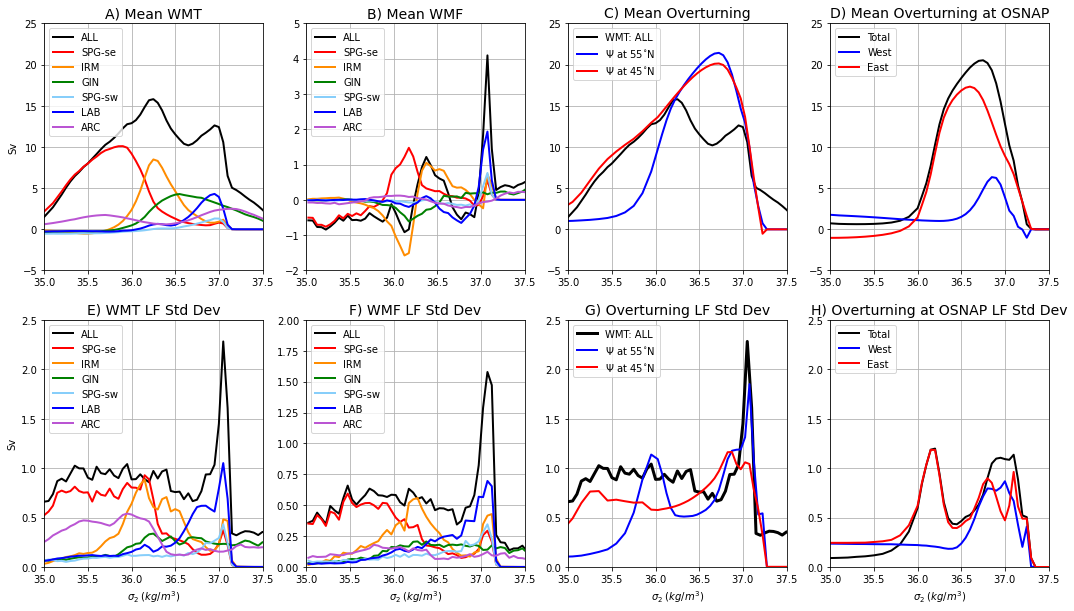

In [11]:
# Mean and Variability of WMT, WMF
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
fsize=14

ylat1 = 55.
ylat2 = 45.
labstr1 = r'$\Psi$ at 55$^{\circ}$N'
labstr2 = r'$\Psi$ at 45$^{\circ}$N'
ylim1 = [-5,25]
xlim = [35.0,37.5]
ylim2 = [0,2.5]
legloc = 'upper left'

simstr = 'HR'
work1 = ds1_hr_mean
work1a = ds1_hr_lpdtstd
work2 = ds2_hr_mean
work2a = ds2_hr_lpdtstd
work3 = ds3_hr_mean
work3a = ds3_hr_lpdtstd

hr_lsw = [36.975, 37.175]
hr_dlsw = [37.075, 37.175]
ax1.set_ylabel('Sv')
ax1.set_ylim(ylim1)
ax1.set_xlim(xlim)
ax1.set_title('A) Mean WMT', fontdict={'size':fsize})
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=0).T,linewidth=2,label='ALL',color='k')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=2).T,linewidth=2,label='SPG-se',color='r')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=3).T,linewidth=2,label='IRM',color='darkorange')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=5).T,linewidth=2,label='GIN',color='g')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=1).T,linewidth=2,label='SPG-sw',color='lightskyblue')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=4).T,linewidth=2,label='LAB',color='b')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=6).T,linewidth=2,label='ARC',color='mediumorchid')
ax1.grid()
ax1.legend(loc=legloc)

#ax2.set_ylabel('Sv')
ax2.set_ylim([-2,5])
ax2.set_xlim(xlim)
ax2.set_title(r'B) Mean WMF', fontdict={'size':fsize})
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=0).T,linewidth=2,label='ALL',color='k')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=2).T,linewidth=2,label='SPG-se',color='r')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=3).T,linewidth=2,label='IRM',color='darkorange')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=5).T,linewidth=2,label='GIN',color='g')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=1).T,linewidth=2,label='SPG-sw',color='lightskyblue')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=4).T,linewidth=2,label='LAB',color='b')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=6).T,linewidth=2,label='ARC',color='mediumorchid')
#ax2.plot(hr_lsw, [-1.5,-1.5],linewidth=7,color='grey',solid_capstyle='butt')
#ax2.plot(hr_dlsw, [-1.5,-1.5],linewidth=7,color='black',solid_capstyle='butt')
#ax2.text(hr_lsw[0]-0.3,-1.6,'LSW')
ax2.grid()
ax2.legend(loc=legloc)

#ax3.set_ylabel('Sv')
ax3.set_ylim(ylim1)
ax3.set_xlim(xlim)
ax3.set_title(r'C) Mean Overturning', fontdict={'size':fsize})
ax3.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=0),linewidth=2,label='WMT: ALL',color='k')
ax3.plot(work2.moc_s, work2.MOCsig.isel(moc_comp=0).isel(transport_reg=1).sel(lat_aux_grid=ylat1,method='nearest').T,linewidth=2,label=labstr1,color='b')
ax3.plot(work2.moc_s, work2.MOCsig.isel(moc_comp=0).isel(transport_reg=1).sel(lat_aux_grid=ylat2,method='nearest').T,linewidth=2,label=labstr2,color='r')
ax3.grid()
ax3.legend(loc=legloc)

#ax4.set_ylabel('Sv')
ax4.set_ylim(ylim1)
ax4.set_xlim(xlim)
ax4.set_title(r'D) Mean Overturning at OSNAP', fontdict={'size':fsize})
ax4.plot(work1.moc_sig2, work1.MOCsig2.isel(moc_comp=0).T,linewidth=2,label='Total',color='k')
ax4.plot(work1.moc_sig2, work1.MOCsig2.isel(moc_comp=1).T,linewidth=2,label='West',color='b')
ax4.plot(work1.moc_sig2, work1.MOCsig2.isel(moc_comp=2).T,linewidth=2,label='East',color='r')
ax4.grid()
ax4.legend(loc=legloc)

ax5.set_ylabel('Sv')
ax5.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')
ax5.set_ylim(ylim2)
ax5.set_xlim(xlim)
ax5.set_title(r'E) WMT LF Std Dev', fontdict={'size':fsize})
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=0).T,linewidth=2,label='ALL',color='k')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=2).T,linewidth=2,label='SPG-se',color='r')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=3).T,linewidth=2,label='IRM',color='darkorange')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=5).T,linewidth=2,label='GIN',color='g')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=1).T,linewidth=2,label='SPG-sw',color='lightskyblue')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=4).T,linewidth=2,label='LAB',color='b')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=6).T,linewidth=2,label='ARC',color='mediumorchid')
ax5.grid()
ax5.legend(loc=legloc)

#ax6.set_ylabel('Sv')
ax6.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')
ax6.set_ylim([0,2])
ax6.set_xlim(xlim)
ax6.set_title(r'F) WMF LF Std Dev', fontdict={'size':fsize})
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=0).T,linewidth=2,label='ALL',color='k')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=2).T,linewidth=2,label='SPG-se',color='r')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=3).T,linewidth=2,label='IRM',color='darkorange')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=5).T,linewidth=2,label='GIN',color='g')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=1).T,linewidth=2,label='SPG-sw',color='lightskyblue')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=4).T,linewidth=2,label='LAB',color='b')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=6).T,linewidth=2,label='ARC',color='mediumorchid')
ax6.grid()
ax6.legend(loc=legloc)

#ax7.set_ylabel('Sv')
ax7.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')
ax7.set_ylim(ylim2)
ax7.set_xlim(xlim)
ax7.set_title(r'G) Overturning LF Std Dev', fontdict={'size':fsize})
ax7.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=0),linewidth=3,label='WMT: ALL',color='k')
ax7.plot(work2a.moc_s, work2a.MOCsig.isel(moc_comp=0).isel(transport_reg=1).sel(lat_aux_grid=ylat1,method='nearest').T,linewidth=2,label=labstr1,color='b')
ax7.plot(work2a.moc_s, work2a.MOCsig.isel(moc_comp=0).isel(transport_reg=1).sel(lat_aux_grid=ylat2,method='nearest').T,linewidth=2,label=labstr2,color='r')
ax7.grid()
ax7.legend(loc=legloc)

#ax8.set_ylabel('Sv')
ax8.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')
ax8.set_ylim(ylim2)
ax8.set_xlim(xlim)
ax8.set_title(r'H) Overturning at OSNAP LF Std Dev', fontdict={'size':fsize})
ax8.plot(work1a.moc_sig2, work1a.MOCsig2.isel(moc_comp=0).T,linewidth=2,label='Total',color='k')
ax8.plot(work1a.moc_sig2, work1a.MOCsig2.isel(moc_comp=1).T,linewidth=2,label='West',color='b')
ax8.plot(work1a.moc_sig2, work1a.MOCsig2.isel(moc_comp=2).T,linewidth=2,label='East',color='r')
ax8.grid()
ax8.legend(loc=legloc)

plt.savefig('Fig_3.pdf')

# fig S3

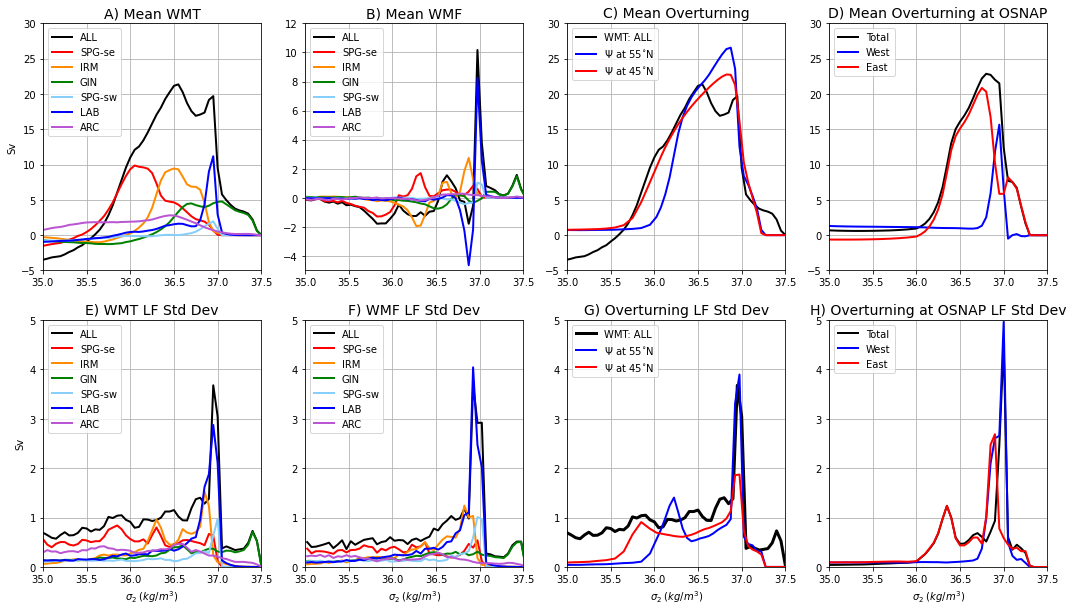

In [12]:
# Mean and Variability of WMT, WMF
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
fsize=14

ylat1 = 55.
ylat2 = 45.
labstr1 = r'$\Psi$ at 55$^{\circ}$N'
labstr2 = r'$\Psi$ at 45$^{\circ}$N'
ylim1 = [-5,30]
xlim = [35.0,37.5]
ylim2 = [0,5]
legloc = 'upper left'

simstr = 'HR'
work1 = ds1_lr_mean
work1a = ds1_lr_lpdtstd
work2 = ds2_lr_mean
work2a = ds2_lr_lpdtstd
work3 = ds3_lr_mean
work3a = ds3_lr_lpdtstd

hr_lsw = [36.975, 37.175]
hr_dlsw = [37.075, 37.175]
ax1.set_ylabel('Sv')
ax1.set_ylim(ylim1)
ax1.set_xlim(xlim)
ax1.set_title('A) Mean WMT', fontdict={'size':fsize})
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=0).T,linewidth=2,label='ALL',color='k')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=2).T,linewidth=2,label='SPG-se',color='r')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=3).T,linewidth=2,label='IRM',color='darkorange')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=5).T,linewidth=2,label='GIN',color='g')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=1).T,linewidth=2,label='SPG-sw',color='lightskyblue')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=4).T,linewidth=2,label='LAB',color='b')
ax1.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=6).T,linewidth=2,label='ARC',color='mediumorchid')
ax1.grid()
ax1.legend(loc=legloc)

#ax2.set_ylabel('Sv')
ax2.set_ylim([-5,12])
ax2.set_xlim(xlim)
ax2.set_title(r'B) Mean WMF', fontdict={'size':fsize})
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=0).T,linewidth=2,label='ALL',color='k')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=2).T,linewidth=2,label='SPG-se',color='r')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=3).T,linewidth=2,label='IRM',color='darkorange')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=5).T,linewidth=2,label='GIN',color='g')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=1).T,linewidth=2,label='SPG-sw',color='lightskyblue')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=4).T,linewidth=2,label='LAB',color='b')
ax2.plot(work3.sigma_wmf, work3.WMF.isel(wmf_region=6).T,linewidth=2,label='ARC',color='mediumorchid')
#ax2.plot(hr_lsw, [-1.5,-1.5],linewidth=7,color='grey',solid_capstyle='butt')
#ax2.plot(hr_dlsw, [-1.5,-1.5],linewidth=7,color='black',solid_capstyle='butt')
#ax2.text(hr_lsw[0]-0.3,-1.6,'LSW')
ax2.grid()
ax2.legend(loc=legloc)

#ax3.set_ylabel('Sv')
ax3.set_ylim(ylim1)
ax3.set_xlim(xlim)
ax3.set_title(r'C) Mean Overturning', fontdict={'size':fsize})
ax3.plot(work3.sigma_wmt, work3.WMT.isel(wmf_region=0),linewidth=2,label='WMT: ALL',color='k')
ax3.plot(work2.moc_s, work2.MOCsig.isel(moc_comp=0).isel(transport_reg=1).sel(lat_aux_grid=ylat1,method='nearest').T,linewidth=2,label=labstr1,color='b')
ax3.plot(work2.moc_s, work2.MOCsig.isel(moc_comp=0).isel(transport_reg=1).sel(lat_aux_grid=ylat2,method='nearest').T,linewidth=2,label=labstr2,color='r')
ax3.grid()
ax3.legend(loc=legloc)

#ax4.set_ylabel('Sv')
ax4.set_ylim(ylim1)
ax4.set_xlim(xlim)
ax4.set_title(r'D) Mean Overturning at OSNAP', fontdict={'size':fsize})
ax4.plot(work1.moc_sig2, work1.MOCsig2.isel(moc_comp=0).T,linewidth=2,label='Total',color='k')
ax4.plot(work1.moc_sig2, work1.MOCsig2.isel(moc_comp=1).T,linewidth=2,label='West',color='b')
ax4.plot(work1.moc_sig2, work1.MOCsig2.isel(moc_comp=2).T,linewidth=2,label='East',color='r')
ax4.grid()
ax4.legend(loc=legloc)

ax5.set_ylabel('Sv')
ax5.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')
ax5.set_ylim(ylim2)
ax5.set_xlim(xlim)
ax5.set_title(r'E) WMT LF Std Dev', fontdict={'size':fsize})
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=0).T,linewidth=2,label='ALL',color='k')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=2).T,linewidth=2,label='SPG-se',color='r')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=3).T,linewidth=2,label='IRM',color='darkorange')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=5).T,linewidth=2,label='GIN',color='g')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=1).T,linewidth=2,label='SPG-sw',color='lightskyblue')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=4).T,linewidth=2,label='LAB',color='b')
ax5.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=6).T,linewidth=2,label='ARC',color='mediumorchid')
ax5.grid()
ax5.legend(loc=legloc)

#ax6.set_ylabel('Sv')
ax6.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')
ax6.set_ylim(ylim2)
ax6.set_xlim(xlim)
ax6.set_title(r'F) WMF LF Std Dev', fontdict={'size':fsize})
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=0).T,linewidth=2,label='ALL',color='k')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=2).T,linewidth=2,label='SPG-se',color='r')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=3).T,linewidth=2,label='IRM',color='darkorange')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=5).T,linewidth=2,label='GIN',color='g')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=1).T,linewidth=2,label='SPG-sw',color='lightskyblue')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=4).T,linewidth=2,label='LAB',color='b')
ax6.plot(work3a.sigma_wmf, work3a.WMF.isel(wmf_region=6).T,linewidth=2,label='ARC',color='mediumorchid')
ax6.grid()
ax6.legend(loc=legloc)

#ax7.set_ylabel('Sv')
ax7.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')
ax7.set_ylim(ylim2)
ax7.set_xlim(xlim)
ax7.set_title(r'G) Overturning LF Std Dev', fontdict={'size':fsize})
ax7.plot(work3a.sigma_wmt, work3a.WMT.isel(wmf_region=0),linewidth=3,label='WMT: ALL',color='k')
ax7.plot(work2a.moc_s, work2a.MOCsig.isel(moc_comp=0).isel(transport_reg=1).sel(lat_aux_grid=ylat1,method='nearest').T,linewidth=2,label=labstr1,color='b')
ax7.plot(work2a.moc_s, work2a.MOCsig.isel(moc_comp=0).isel(transport_reg=1).sel(lat_aux_grid=ylat2,method='nearest').T,linewidth=2,label=labstr2,color='r')
ax7.grid()
ax7.legend(loc=legloc)

#ax8.set_ylabel('Sv')
ax8.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')
ax8.set_ylim(ylim2)
ax8.set_xlim(xlim)
ax8.set_title(r'H) Overturning at OSNAP LF Std Dev', fontdict={'size':fsize})
ax8.plot(work1a.moc_sig2, work1a.MOCsig2.isel(moc_comp=0).T,linewidth=2,label='Total',color='k')
ax8.plot(work1a.moc_sig2, work1a.MOCsig2.isel(moc_comp=1).T,linewidth=2,label='West',color='b')
ax8.plot(work1a.moc_sig2, work1a.MOCsig2.isel(moc_comp=2).T,linewidth=2,label='East',color='r')
ax8.grid()
ax8.legend(loc=legloc)

plt.savefig('fig_S3.pdf')